<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_holtwinters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import warnings
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = (13, 7)

In [3]:
!pip3 install --upgrade statsmodels
clear_output()

     |████████████████████████████████| 9.5MB 3.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Import monthly data

In [4]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

df.set_index('date', inplace=True)

# cut train period

train = df[(df.index >= '2000-01-01') & (df.index <= '2019-12-01')]

test = df[df.index >= '2019-01-01']

## Flag first full year of data

In [5]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

min_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'))['min_year'].dt.year+1

df = pd.merge(df,min_year,how='left',left_on=df.cd_estacao,right_on=min_year.index)

df.drop(columns='key_0', inplace=True)

KeyboardInterrupt: ignored

## Exploratory

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [7]:
strain = train[(train['dc_nome']=='sinop') & (train.index>='2009-01-01') & (train.index<'2020-01-01')].chuva
stest = test[(test['dc_nome']=='sinop') & (test.index>='2020-01-01')].chuva

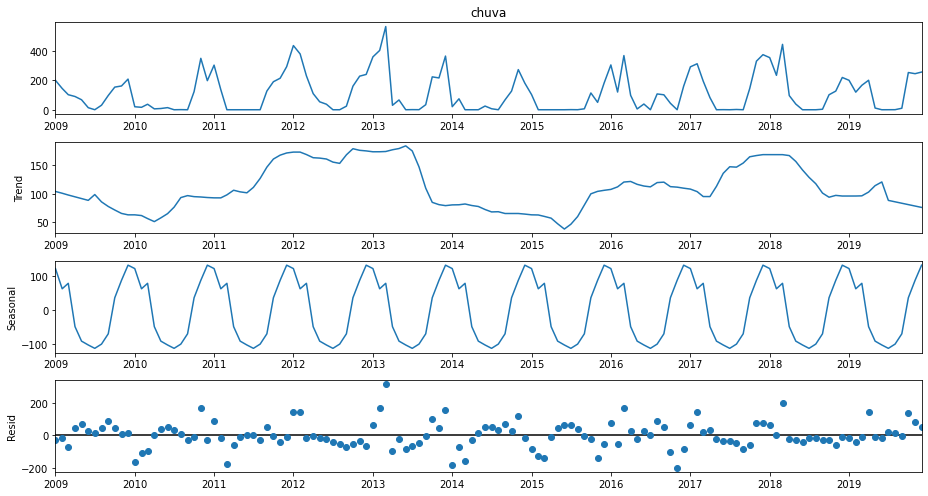

In [8]:
# time series decomposition

res = sm.tsa.seasonal_decompose(strain, period=12, extrapolate_trend='freq')
resplot = res.plot()

In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

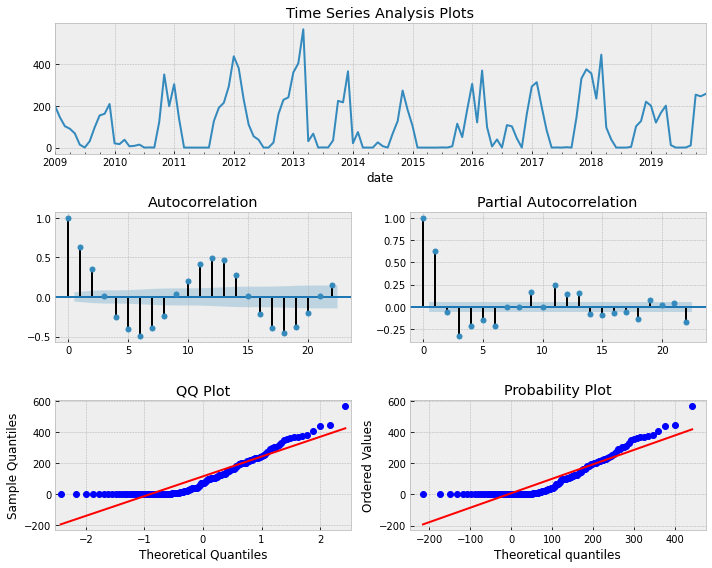

In [10]:
tsplot(strain)

## Holt-Winters

In [ ]:
strain1 = strain.copy()
strain1.index = pd.date_range(start='2009-01', end='2020-01', freq='M')

In [ ]:
fit1 = smt.ExponentialSmoothing(strain1, seasonal_periods=4, trend='add', seasonal='mul', initialization_method="estimated", freq='M').fit()
fit2 = smt.ExponentialSmoothing(strain1, seasonal_periods=4, trend='add', seasonal='add', damped_trend=True, initialization_method="estimated", freq='M').fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Additive Dam"]   = [fit2.params[p] for p in params] + [fit2.sse]

ax = strain1.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='o', color='red', legend=True)
fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)

plt.show()
print("Forecasting for precipitation in Sinop")

results